In [1]:
from data_extraction import extract_text_from_pdf, read_text_file

In [2]:
import csv
import pandas as pd

2025-04-28 19:40:14,994 - numexpr.utils - INFO - NumExpr defaulting to 10 threads.


In [3]:

df = pd.read_csv('./data/job/Accountant.csv')
print(df.head(5)['Job description'][3])

Accountant - AP (Yearly Contract)
Job Description
 Role purpose
Accountant ( AP ) is responsible for receiving, processing, and verifying invoices related to accounts payables. The role of an Accounts Payable is to provide financial and administrative support for the organization. They process payments, verify invoices and reconcile all expenses to keep track of what's going out of the business.
Accountabilities
Completing day-to-day accounts payable activities and operations, including managing and maintaining accounts payable, ensuring accuracy and timeliness.
Upload vendor invoice in self-scan portal
Manage Vendor payment details to ensure there are no errors when processing payments.
Prepared Vat report and document support
Prepared withholding tax report & submission
Prepared withholding tax from Concur system (100-150 items per entities, in total 3 entities)
Reconcile outstanding payments for concur system on an ongoing basis to ensure no orders or payments are missed or unmatche

In [4]:
import os
import re
import numpy as np
import pandas as pd
from typing import List, Tuple, Dict
import string
import nltk
import scipy.sparse as sp
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

# New imports for BERT with TensorFlow
from transformers import TFBertModel, AutoTokenizer, TFAutoModel
import tensorflow as tf

# Download necessary NLTK resources
nltk.download("punkt", quiet=True)
nltk.download("averaged_perceptron_tagger", quiet=True)
nltk.download("wordnet", quiet=True)
nltk.download("stopwords", quiet=True)


class BiasedDocumentMatcher:
    def __init__(self, config: Dict = None, extra_keywords: List[str] = None):
        """
        Advanced document matching with configurable NLP techniques and keyword scoring

        Args:
            config (Dict): Configuration dictionary for matching
            extra_keywords (List[str]): List of keywords to give extra points for
        """
        # Default configuration
        self.config = {
            "remove_stopwords": True,
            "lemmatize": True,
            "similarity_method": "bow",  # Options: "bow", "tfidf", or "bert"
            "use_keywords": True,
            "keyword_weight": 0.01,  # Weight for extra keywords
        }

        # Update with user-provided configuration
        if config:
            self.config.update(config)

        # Initialize extra keywords
        self.extra_keywords = set(extra_keywords) if extra_keywords else set()

        # Initialize resources for classical NLP methods
        self.lemmatizer = WordNetLemmatizer()
        self.stop_words = (
            set(stopwords.words("english"))
            if self.config["remove_stopwords"]
            else set()
        )
        # Verb tags to remove
        self.verb_tags = ["VB", "VBD", "VBG", "VBN", "VBP", "VBZ"]

        # If using BERT for similarity, initialize the tokenizer and TensorFlow model.
        if self.config["similarity_method"] == "bert":
            #TensorFlow compatible SBERT model from Hugging Face.
            self.tokenizer = AutoTokenizer.from_pretrained("sentence-transformers/all-MiniLM-L6-v2")
            self.model = TFAutoModel.from_pretrained("sentence-transformers/all-MiniLM-L6-v2")

    def get_bert_embedding(self, text: str) -> np.ndarray:
        """
        Get BERT embedding for the given text using TensorFlow

        Args:
            text (str): Input text

        Returns:
            np.ndarray: Dense embedding vector
        """
        # Tokenize and encode text using BERT's tokenizer with TensorFlow tensors.
        inputs = self.tokenizer(text, return_tensors="tf", truncation=True, padding=True)
        outputs = self.model(inputs)
        # Mean pool over token embeddings (last_hidden_state shape: [batch_size, seq_len, hidden_size])
        embedding = tf.reduce_mean(outputs.last_hidden_state, axis=1).numpy()[0]
        return embedding
    
    def process_texts(self, text: str) -> str:
        text = text.lower()
        text = re.sub('\n', ' ', text)  # remove new line characters
        text  = re.sub('http\S+\s*', ' ', text)  # remove URLs
        text = re.sub(r'[^\x00-\x7f]',r' ', text) #remove extra characters
        text = re.sub('\s+', ' ', text)  # remove extra whitespace        
        text = re.sub('[^a-zA-Z1-9]', ' ', text)
        return text

    def process_tokens(self, text: str) -> List[str]:
        """
        Advanced text preprocessing

        Args:
            text (str): Input text

        Returns:
            List[str]: Preprocessed tokens
        """
        #text = re.sub(r"[^a-zA-Z1-9\s]", "", text)
        tokens = word_tokenize(text)
        # Part of speech tagging
        pos_tags = nltk.pos_tag(tokens)

        # Preprocessing
        processed_tokens = []
        for token, pos in pos_tags:
            # Skip numbers
            if token.isdigit():
                continue

            # Lemmatize
            if self.config["lemmatize"]:
                token = self.lemmatizer.lemmatize(token)

            # Skip stopwords
            if self.config["remove_stopwords"] and token in self.stop_words:
                continue

            # Skip verbs
            if pos in self.verb_tags:
                continue

            # Skip grammatical words
            if pos in ['DT', 'IN', 'TO', 'PRP', 'WP']:
                continue

            processed_tokens.append(token)

        return processed_tokens

    def add_extra_keywords(self, new_keywords: List[str]) -> None:
        """
        Add extra keywords to give bonus points

        Args:
            new_keywords (List[str]): List of keywords to add
        """
        self.extra_keywords.update(new_keywords)

    def calculate_keyword_bonus(self, doc_tokens: List[str]) -> float:
        """
        Calculate bonus points for extra keywords

        Args:
            doc_tokens (List[str]): Preprocessed document tokens

        Returns:
            float: Keyword bonus score
        """
        bonus = 0
        if self.config["use_keywords"]:
            # Find matches between document tokens and extra keywords
            keyword_matches = set(doc_tokens) & self.extra_keywords
            # Calculate bonus based on number of matches
            bonus = len(keyword_matches) * self.config["keyword_weight"]
        return bonus



    def calculate_similarity(self, doc1_text: str, doc2_text: str) -> float:
        """
        Calculate advanced similarity between two documents

        Args:
            doc1_text (str): First document
            doc2_text (str): Second document

        Returns:
            float: Similarity score
        """
        #Basic clean up
        doc1_text = self.process_texts(doc1_text)
        doc2_text = self.process_texts(doc2_text)

        # Calculate keyword bonus for the first document
        doc1_tokens = self.process_tokens(doc1_text)
        keyword_bonus = self.calculate_keyword_bonus(doc1_tokens)

        # Choose vectorization method based on configuration
        if self.config["similarity_method"] == "bert":
            # Use BERT embeddings (TensorFlow version)
            emb1 = self.get_bert_embedding(doc1_text)
            emb2 = self.get_bert_embedding(doc2_text)
            similarity = cosine_similarity([emb1], [emb2])[0][0]
        else:
            # For "tfidf" or "bow", preprocess the text into tokens first.
            doc1_tokens = self.process_tokens(doc1_text)
            doc2_tokens = self.process_tokens(doc2_text)

            # Choose vectorizer based on configuration
            if self.config["similarity_method"] == "tfidf":
                vectorizer = TfidfVectorizer(
                    preprocessor=self.process_tokens,
                    tokenizer=lambda x: x,
                    lowercase=False,
                )
            else:  # Default: Bag of Words
                vectorizer = CountVectorizer(
                    preprocessor=self.process_tokens,
                    tokenizer=lambda x: x,
                    lowercase=False,
                )
            # Combine documents for vectorization
            doc_matrix = vectorizer.fit_transform(
                [" ".join(doc1_tokens), " ".join(doc2_tokens)]
            )
            similarity = cosine_similarity(doc_matrix[0:1], doc_matrix[1:2])[0][0]

        # Combine similarity with keyword bonus
        final_score = similarity + keyword_bonus
        return final_score


In [ ]:
import os
from matcher import BiasedDocumentMatcher

def main():
    method = 'bow'
    
    Amatcher = BiasedDocumentMatcher({
        'remove_stopwords': True,
        'lemmatize': True,
        'similarity_method': method,  # Can be 'tfidf' or 'bow'
    })

    Matchers = [ Amatcher]

    # Directories containing the files
    job_description_folder = 'job_texts'
    resume_folder = 'resume_texts'

    # Loop through files in the job description folder
    for job_description_filename in os.listdir(job_description_folder):
        job_description_path = os.path.join(job_description_folder, job_description_filename)
        resume_similarities = []
        
        job_description = read_text_file(job_description_path).strip()

        # Loop through files in the resume folder
        for resume_filename in os.listdir(resume_folder):
            resume_path = os.path.join(resume_folder, resume_filename)
            resume = read_text_file(resume_path).strip()
            res = [matcher.calculate_similarity(job_description, resume) for matcher in Matchers]
            resume_similarities.append((res, resume_filename))

        # Sort and print top matches (Sort by first similarity score)
        resume_similarities.sort(reverse=True, key=lambda x: x[0])
        print()
        print(f"Top 5 Matches for {job_description_filename}:")
        for i, (res, resume_filename) in enumerate(resume_similarities):
            score_str = ', '.join(f"{s:.2f}" for s in res)
            print(f"{i+1}. {resume_filename}: {score_str}")

if __name__ == "__main__":
    main()


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['embeddings.position_ids']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.



Top 5 Matches for FE2.txt:
1. frontend_claude.txt: 0.68
2. frontend_genie.txt: 0.67
3. frontend.txt: 0.58
4. tester.txt: 0.34
5. dataeng.txt: 0.31
6. accounting.txt: 0.25
7. law.txt: 0.15

Top 5 Matches for FE.txt:
1. frontend_genie.txt: 0.63
2. frontend_claude.txt: 0.56
3. frontend.txt: 0.51
4. tester.txt: 0.33
5. dataeng.txt: 0.28
6. accounting.txt: 0.11
7. law.txt: 0.08

Top 5 Matches for TE.txt:
1. tester.txt: 0.57
2. dataeng.txt: 0.37
3. frontend_genie.txt: 0.34
4. frontend.txt: 0.27
5. accounting.txt: 0.27
6. frontend_claude.txt: 0.27
7. law.txt: 0.26

Top 5 Matches for DE.txt:
1. dataeng.txt: 0.69
2. tester.txt: 0.48
3. frontend_claude.txt: 0.40
4. frontend_genie.txt: 0.37
5. frontend.txt: 0.37
6. accounting.txt: 0.32
7. law.txt: 0.29


Top 5 Matches for FE2.txt:
1. frontend_claude.txt: 0.68
2. frontend_genie.txt: 0.67
3. frontend.txt: 0.58
4. tester.txt: 0.34
5. dataeng.txt: 0.31
6. accounting.txt: 0.25
7. law.txt: 0.15

Top 5 Matches for FE.txt:
1. frontend_genie.txt: 0.63
2. frontend_claude.txt: 0.56
3. frontend.txt: 0.51
4. tester.txt: 0.33
5. dataeng.txt: 0.28
6. accounting.txt: 0.11
7. law.txt: 0.08

Top 5 Matches for TE.txt:
1. tester.txt: 0.57
2. dataeng.txt: 0.37
3. frontend_genie.txt: 0.34
4. frontend.txt: 0.27
5. accounting.txt: 0.27
6. frontend_claude.txt: 0.27
7. law.txt: 0.26

Top 5 Matches for DE.txt:
1. dataeng.txt: 0.69
2. tester.txt: 0.48
3. frontend_claude.txt: 0.40
4. frontend_genie.txt: 0.37
5. frontend.txt: 0.37
6. accounting.txt: 0.32
7. law.txt: 0.29

Measuring Performance

In [7]:
import pandas as pd
import os

# Directories containing the files
job_description_folder = './data/job'
resume_folder = 'data/resume'

dfs = []
# Loop through files in the job description folder
for job_description_filename in os.listdir(job_description_folder):
    job_description_path = os.path.join(job_description_folder, job_description_filename)
    dfs.append(pd.read_csv(job_description_path))
job_df = pd.concat(dfs).reset_index(drop=True)
display(job_df)

resume_df = pd.read_csv(os.path.join(resume_folder, 'fe_resumes.csv'))
display(resume_df)

,Job Title,Job description
0,interior design,Interior Design Service Specialist - IKEA Bang...
1,interior design,Intermediate Interior Designer\nFull job descr...
2,interior design,Senior Interior Designer\nAbout this role:\nTh...
3,interior design,Interior Designer - Workplace - Mid Level\nFul...
4,interior design,Senior FF&E Designer / FF&E Designer\nFull job...
5,Lawyer,"Lawyer\nROLE & RESPONSIBILITY\nDraft, review, ..."
6,Lawyer,Lawyer - Litigator\nFull job description\nLawy...
7,Lawyer,TRANSACTIONAL LAWYER URGENT\nJob Descriptions ...
8,Lawyer,Junior-Level / Mid-Level Associate: Litigation...
9,Lawyer,Senior Corporate Lawyer (5+ Years’ Experience)...


,Job Title,resume,score
0,Front-end Developer,\nSummary: Experienced Front-End Developer wit...,10
1,Front-end Developer,\nSummary: Front-End Developer with 4 years of...,8
2,Front-end Developer,\nSummary: Entry-level Front-End Developer wit...,6
3,Front-end Developer,\nSummary: Beginner Front-End Developer learni...,4
4,Front-end Developer,\nSummary: Recent high school graduate explori...,2
5,Front-end Developer,"\nSummary: Aspiring web developer, currently l...",1
6,Front-end Developer,\nSummary: Interested in learning web developm...,0
7,Front-end Developer,Summary:\n\nHighly motivated and experienced F...,10
8,Front-end Developer,Summary:\n\nFront-End Developer with 5 years o...,8
9,Front-end Developer,\n\nSummary:\n\nEnthusiastic Front-End Develop...,6


From the result, the current configuration seems to work for matching 
the right resume to the right jobs (or at least similar jobs)
- Higher score resume seems to match with more jobs
- The score of the resume seems to correspond with the similarity score but this isn't a strong relationship
- perhaps moving the threshold of 0.5 up will filter up the noises?
- poor precision but good recall for better resumes (matches with more jobs)
- poor recall but good precision for worse resumes (matches with less jobs)
- So far F1 Score of 0.7 is pretty solid

In [13]:
Amatcher = BiasedDocumentMatcher({
    'remove_stopwords': True,
    'lemmatize': True,
    'similarity_method': 'bow',  # Can be 'tfidf' or 'bow'
})
Amatcher.calculate_similarity('I am Kong Mac', 'I am Kong Mac')

/opt/anaconda3/envs/testenv/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


0.9999999999999998

In [27]:
import matplotlib.pyplot as plt

# Initialize lists to store precision, recall, F1 scores, and resume scores per iteration
precision_scores = []
recall_scores = []
f1_scores = []
resume_scores = []  # List to track each resume's base score
thresh_hold =  0.52 if (Amatcher.config['similarity_method'] == 'bert') else 0.25
print('similarity_method', Amatcher.config['similarity_method'])
print('thresh_hold', thresh_hold)   

# Process only the first 10 resumes
for idx, resume in resume_df.iterrows():
    print(f"Index: {idx}, Title: {resume['Job Title']}, Score: {resume['score']}")
    
    # Retrieve jobs with similarity above threshold
    res = [
        (score, job['Job Title'], index)
        for index, job in job_df.iterrows()
        if (score := Amatcher.calculate_similarity(job['Job description'], resume['resume'])) > thresh_hold
    ]
    
    # Compute precision: correct retrieved / retrieved
    correct = sum(job_title == resume['Job Title'] for _, job_title, index in res)
    precision = correct / len(res) if res else 0
    print(f'Precision score = {precision}')
    
    # Compute recall: correct retrieved / total relevant items from job_df
    total_relevant = sum(1 for _, job in job_df.iterrows() if job['Job Title'] == resume['Job Title'])
    recall = correct / total_relevant if total_relevant else 0
    print(f'Recall score = {recall}')
    
    # Compute the F1 score for this resume (harmonic mean of precision and recall)
    if precision + recall:
        f1 = 2 * (precision * recall) / (precision + recall)
    else:
        f1 = 0
    print(f'F1 score = {f1}')
    
    # Store computed metrics along with the resume's score
    precision_scores.append(precision)
    recall_scores.append(recall)
    f1_scores.append(f1)
    resume_scores.append(resume['score'])
    
    # Optionally, sort and display the filtered results
    res = sorted(res, key=lambda x: x[0], reverse=True)
    display(res)

# Calculate aggregate (mean) scores over all evaluated resumes
mean_precision = sum(precision_scores) / len(precision_scores) if precision_scores else 0
mean_recall = sum(recall_scores) / len(recall_scores) if recall_scores else 0
mean_f1 = sum(f1_scores) / len(f1_scores) if f1_scores else 0

print(f"Mean Precision: {mean_precision}")
print(f"Mean Recall: {mean_recall}")
print(f"Mean F1 Score: {mean_f1}")


similarity_method bow
thresh_hold 0.25
Index: 0, Title: Front-end Developer, Score: 10


/opt/anaconda3/envs/testenv/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Precision score = 0.5555555555555556
Recall score = 1.0
F1 score = 0.7142857142857143


[(0.5385478784528956, 'Front-end Developer', 20),
 (0.48232271198807425, 'Front-end Developer', 24),
 (0.3982883927635237, 'Front-end Developer', 22),
 (0.3221428561209475, 'Front-end Developer', 23),
 (0.3212335750717256, 'UX/UI Designer', 39),
 (0.2897800034632232, 'UX/UI Designer', 37),
 (0.2860329300064626, 'Front-end Developer', 21),
 (0.281964557471881, 'UX/UI Designer', 36),
 (0.27127233568620035, 'UX/UI Designer', 35)]

Index: 1, Title: Front-end Developer, Score: 8
Precision score = 0.7142857142857143
Recall score = 1.0
F1 score = 0.8333333333333333


[(0.3971420353928973, 'Front-end Developer', 20),
 (0.35684600399610217, 'Front-end Developer', 24),
 (0.34591272541619794, 'Front-end Developer', 22),
 (0.3026247039837124, 'Front-end Developer', 23),
 (0.26455339102035585, 'UX/UI Designer', 39),
 (0.26285075875398495, 'Front-end Developer', 21),
 (0.2575273328799892, 'UX/UI Designer', 36)]

Index: 2, Title: Front-end Developer, Score: 6
Precision score = 0.5
Recall score = 0.6
F1 score = 0.5454545454545454


[(0.337563335568336, 'Front-end Developer', 22),
 (0.31283708834989793, 'Front-end Developer', 24),
 (0.30407111984631574, 'Front-end Developer', 20),
 (0.29578894849433035, 'PR', 13),
 (0.25862070705646906, 'UX/UI Designer', 36),
 (0.2525089430506066, 'Project Manager', 43)]

Index: 3, Title: Front-end Developer, Score: 4
Precision score = 0.5
Recall score = 0.4
F1 score = 0.4444444444444445


[(0.3102526139970116, 'Front-end Developer', 20),
 (0.30337042282559146, 'Front-end Developer', 24),
 (0.29809403520609357, 'PR', 13),
 (0.2800773617251715, 'Project Manager', 43)]

Index: 4, Title: Front-end Developer, Score: 2
Precision score = 0.0
Recall score = 0.0
F1 score = 0


[(0.31031405931277184, 'Project Manager', 43),
 (0.30741401256374123, 'PR', 13),
 (0.2619768586485044, 'UX/UI Designer', 36)]

Index: 5, Title: Front-end Developer, Score: 1
Precision score = 0.5
Recall score = 0.2
F1 score = 0.28571428571428575


[(0.2860387767736777, 'Front-end Developer', 20),
 (0.2556549962824568, 'PR', 13)]

Index: 6, Title: Front-end Developer, Score: 0
Precision score = 0.5
Recall score = 0.6
F1 score = 0.5454545454545454


[(0.3211586167968363, 'Front-end Developer', 24),
 (0.30795659029143735, 'Front-end Developer', 20),
 (0.2763032760629309, 'PR', 13),
 (0.26926023193385334, 'Accountant', 17),
 (0.2580672563510211, 'UX/UI Designer', 36),
 (0.2549895403411334, 'Front-end Developer', 22)]

Index: 7, Title: Front-end Developer, Score: 10
Precision score = 1.0
Recall score = 1.0
F1 score = 1.0


[(0.5100427049499138, 'Front-end Developer', 24),
 (0.4796708164492163, 'Front-end Developer', 20),
 (0.38625011824308925, 'Front-end Developer', 22),
 (0.3548226652329635, 'Front-end Developer', 21),
 (0.3442906644675542, 'Front-end Developer', 23)]

Index: 8, Title: Front-end Developer, Score: 8
Precision score = 1.0
Recall score = 1.0
F1 score = 1.0


[(0.4737343585008823, 'Front-end Developer', 24),
 (0.45159946371036763, 'Front-end Developer', 22),
 (0.4453617714151233, 'Front-end Developer', 20),
 (0.3129241488308675, 'Front-end Developer', 23),
 (0.3111411189859678, 'Front-end Developer', 21)]

Index: 9, Title: Front-end Developer, Score: 6
Precision score = 1.0
Recall score = 0.8
F1 score = 0.888888888888889


[(0.4621247905424448, 'Front-end Developer', 24),
 (0.45898198959944086, 'Front-end Developer', 22),
 (0.3238243059644652, 'Front-end Developer', 20),
 (0.28347198591226747, 'Front-end Developer', 23)]

Index: 10, Title: Front-end Developer, Score: 4
Precision score = 0.75
Recall score = 0.6
F1 score = 0.6666666666666665


[(0.3712763847138057, 'Front-end Developer', 24),
 (0.32613628142846846, 'Front-end Developer', 22),
 (0.29268470350248177, 'Front-end Developer', 20),
 (0.2559073376997336, 'Accountant', 17)]

Index: 11, Title: Front-end Developer, Score: 2
Precision score = 1.0
Recall score = 0.6
F1 score = 0.7499999999999999


[(0.3557220909362623, 'Front-end Developer', 24),
 (0.3251280443811775, 'Front-end Developer', 20),
 (0.2840335121348202, 'Front-end Developer', 22)]

Index: 12, Title: Front-end Developer, Score: 1
Precision score = 1.0
Recall score = 0.4
F1 score = 0.5714285714285715


[(0.2834427073321315, 'Front-end Developer', 24),
 (0.2687165276058996, 'Front-end Developer', 20)]

Index: 13, Title: Front-end Developer, Score: 0
Precision score = 0.2
Recall score = 0.4
F1 score = 0.26666666666666666


[(0.29654628389589077, 'UX/UI Designer', 39),
 (0.29424494316824984, 'interior design', 3),
 (0.28527253168763633, 'interior design', 1),
 (0.28253331287884864, 'interior design', 2),
 (0.2805982234399535, 'UX/UI Designer', 37),
 (0.2804228224858032, 'UX/UI Designer', 36),
 (0.2628571428571429, 'Front-end Developer', 24),
 (0.2572193422299569, 'UX/UI Designer', 38),
 (0.2538104854868824, 'UX/UI Designer', 35),
 (0.25226248955475655, 'Front-end Developer', 20)]

Index: 14, Title: Front-end Developer, Score: 10
Precision score = 0.4166666666666667
Recall score = 1.0
F1 score = 0.5882352941176471


[(0.6914700026038172, 'Front-end Developer', 24),
 (0.5706724103945344, 'Front-end Developer', 20),
 (0.5416116247530579, 'Front-end Developer', 21),
 (0.4106927117044294, 'Front-end Developer', 22),
 (0.3989464844629261, 'Front-end Developer', 23),
 (0.3432157772974153, 'UX/UI Designer', 35),
 (0.33985612857294667, 'UX/UI Designer', 39),
 (0.31285914987568386, 'UX/UI Designer', 37),
 (0.2869659059149019, 'UX/UI Designer', 36),
 (0.27890148178550683, 'UX/UI Designer', 38),
 (0.2618044364915348, 'interior design', 2),
 (0.2580947460348446, 'interior design', 3)]

Index: 15, Title: Front-end Developer, Score: 9
Precision score = 1.0
Recall score = 1.0
F1 score = 1.0


[(0.38949159644811826, 'Front-end Developer', 24),
 (0.3801498681989777, 'Front-end Developer', 20),
 (0.33871550327940486, 'Front-end Developer', 22),
 (0.2864933077957473, 'Front-end Developer', 23),
 (0.261281486467507, 'Front-end Developer', 21)]

Index: 16, Title: Front-end Developer, Score: 7
Precision score = 1.0
Recall score = 1.0
F1 score = 1.0


[(0.47591830080769476, 'Front-end Developer', 24),
 (0.4020151261036848, 'Front-end Developer', 20),
 (0.35480236941044635, 'Front-end Developer', 23),
 (0.324976299987061, 'Front-end Developer', 22),
 (0.2963119559695384, 'Front-end Developer', 21)]

Index: 17, Title: Front-end Developer, Score: 6
Precision score = 1.0
Recall score = 1.0
F1 score = 1.0


[(0.5343155318326465, 'Front-end Developer', 24),
 (0.42121176958711604, 'Front-end Developer', 20),
 (0.4181508441475623, 'Front-end Developer', 22),
 (0.34636483416229824, 'Front-end Developer', 21),
 (0.2682927058517136, 'Front-end Developer', 23)]

Index: 18, Title: Front-end Developer, Score: 4
Precision score = 1.0
Recall score = 0.8
F1 score = 0.888888888888889


[(0.4259177099999599, 'Front-end Developer', 24),
 (0.38550794895160617, 'Front-end Developer', 22),
 (0.3491899510776647, 'Front-end Developer', 20),
 (0.31898291764623027, 'Front-end Developer', 23)]

Index: 19, Title: Front-end Developer, Score: 3
Precision score = 0.75
Recall score = 0.6
F1 score = 0.6666666666666665


[(0.29906687176753616, 'Front-end Developer', 24),
 (0.29423079099340255, 'Front-end Developer', 22),
 (0.26195608894247147, 'Front-end Developer', 20),
 (0.2527603229943381, 'UX/UI Designer', 36)]

Mean Precision: 0.7193253968253968
Mean Recall: 0.7
Mean F1 Score: 0.6828064256005433


## SBERT at 0.52 threshold
- Mean Precision: 0.806686507936508
- Mean Recall: 0.7100000000000001
- Mean F1 Score: 0.7090639915639916
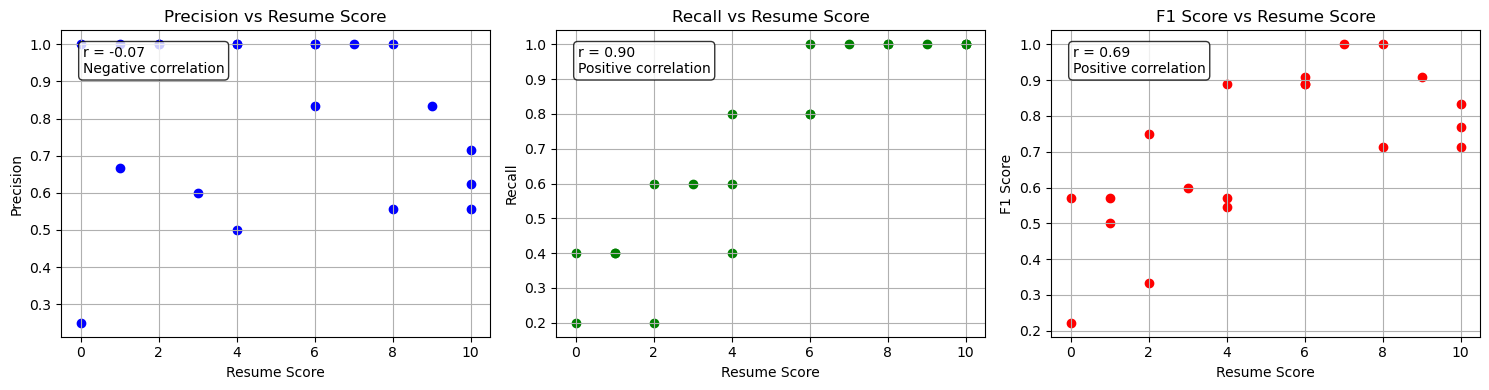


## BOW at 0.25 threshold
- Mean Precision: 0.7193253968253968
- Mean Recall: 0.7
- Mean F1 Score: 0.6828064256005433
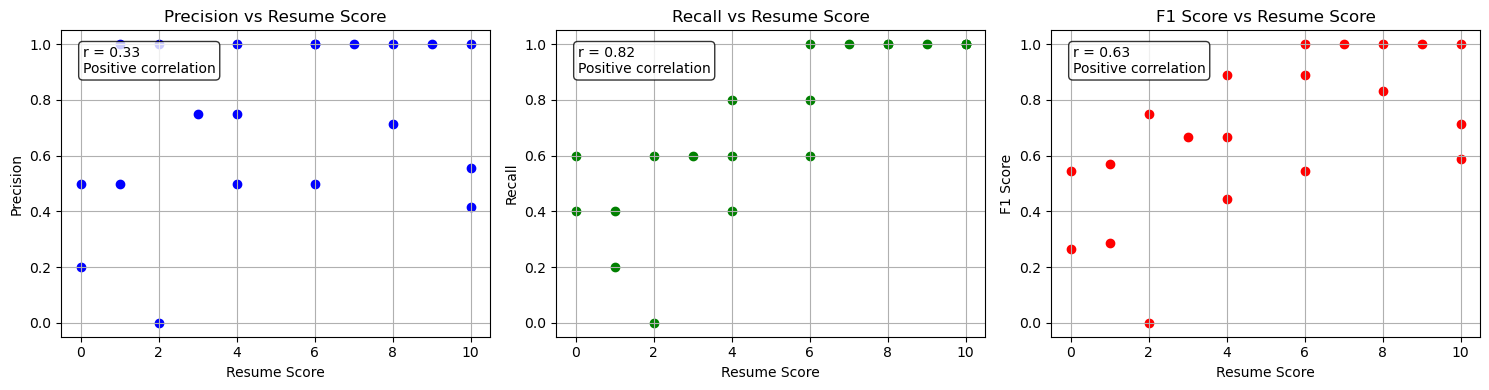

SBERT has higher mean precision at the cost of much slower runtime

How good is it for ranking candidate: nDCG
- when resumes have varying levels of relevance, and the position in the ranking matters

In [17]:
import numpy as np

def dcg_at_k(relevances, k):
    """Compute DCG@k for a list of graded relevances."""
    relevances = np.asfarray(relevances)[:k]
    if relevances.size == 0:
        return 0.0
    # DCG formula: first item + discounted sum of rest
    return relevances[0] + np.sum(relevances[1:] / np.log2(np.arange(2, relevances.size + 1)))

def ndcg_at_k(predicted_rels, true_rels, k):
    """
    Compute nDCG@k given:
      - predicted_rels: list of true relevance scores in predicted order
      - true_rels: list of true relevance scores (unsorted)
      - k: cutoff rank
    """
    # DCG of predicted order
    dcg_value = dcg_at_k(predicted_rels, k)
    # DCG of ideal (sorted) order
    ideal_rels = sorted(true_rels, reverse=True)
    idcg_value = dcg_at_k(ideal_rels, k)
    return dcg_value / idcg_value if idcg_value > 0 else 0.0


In [24]:
fe_job_df = job_df[job_df['Job Title'] == 'Front-end Developer']
fe_job_df

,Job Title,Job description
20,Front-end Developer,Front-End Flutter & React\nMain Responsibiliti...
21,Front-end Developer,Front-End Developer (React)\nResponsibilities:...
22,Front-end Developer,Junior Front-End Developer\nFull job descripti...
23,Front-end Developer,Front-End Developer\nAbout the job:\nAs a .NET...
24,Front-end Developer,Front-End Developer\nPaired is a global staffi...


In [29]:
Amatcher = BiasedDocumentMatcher({
    'remove_stopwords': True,
    'lemmatize': True,
    'similarity_method': 'bert',  # Can be 'tfidf' or 'bow'
})
Amatcher.calculate_similarity('I am Kong Mac', 'I am Kong Mac')

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['embeddings.position_ids']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


1.0

In [ ]:
thresh_hold =  0.52 if (Amatcher.config['similarity_method'] == 'bert') else 0.25
print('similarity_method', Amatcher.config['similarity_method'])
print('thresh_hold', thresh_hold)   
ndcg_scores = []

for job_idx, job in fe_job_df.iterrows():
    # 1. Filter and rank resumes by match_score
    filtered = [
        (resume_idx, resume['score'], Amatcher.calculate_similarity(job['Job description'], resume['resume']))
        for resume_idx, resume in resume_df.iterrows()
        if Amatcher.calculate_similarity(job['Job description'], resume['resume']) > thresh_hold
    ]
    # Sort by predicted similarity descending
    filtered.sort(key=lambda x: x[2], reverse=True)

    # 2. Extract the true relevance scores in predicted order
    predicted_true_rels = [true_score for (_, true_score, _) in filtered]
    # 3. Extract all true relevance scores for this job (for ideal order)
    all_true_rels = list(resume_df['score'])

    # 4. Compute nDCG@K (K = number of filtered resumes)
    k = len(predicted_true_rels)
    ndcg_score = ndcg_at_k(predicted_true_rels, all_true_rels, k)
    ndcg_scores.append(ndcg_score)
    print(f"Job {job_idx} ({job['Job Title']}): nDCG@{k} = {ndcg_score:.4f}")

    display(filtered)

mean_nDCG = sum(ndcg_scores) / len(ndcg_scores) if ndcg_scores else 0

print(f"Mean nDCG: {mean_nDCG}")

BOW: Mean nDCG 0.9374967427695198
SBERT: Mean nDCG 0.9176263729170604
# Tested with very small samples

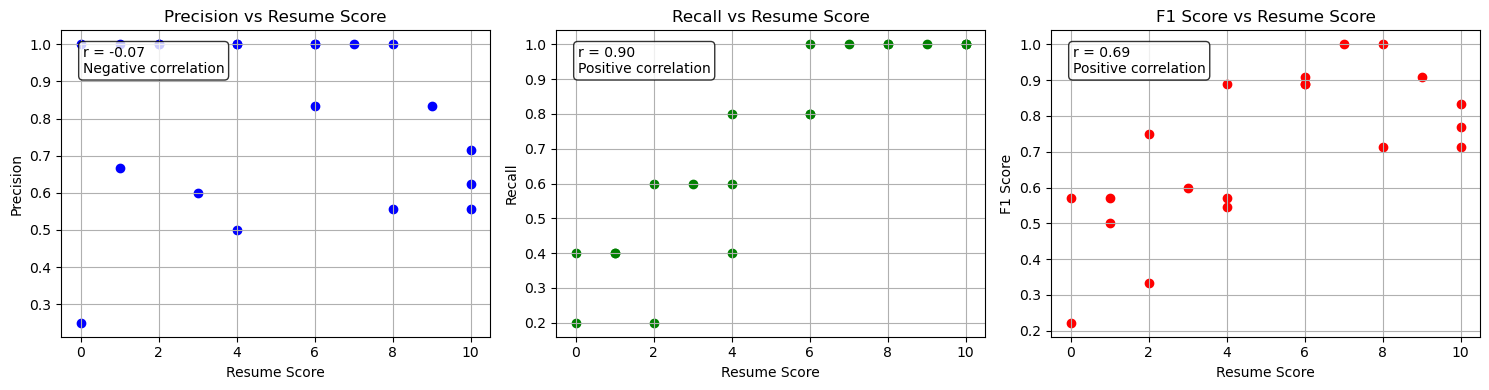

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Compute correlation coefficients for each metric vs resume score
corr_precision = np.corrcoef(resume_scores, precision_scores)[0, 1]
corr_recall    = np.corrcoef(resume_scores, recall_scores)[0, 1]
corr_f1      = np.corrcoef(resume_scores, f1_scores)[0, 1]

# A helper function to determine the correlation type
def get_correlation_type(corr, threshold=0.05):
    # If abs(corr) is less than threshold, we consider it no correlation
    if abs(corr) < threshold:
        return "No correlation"
    elif corr > 0:
        return "Positive correlation"
    else:
        return "Negative correlation"

# Determine correlation types
corr_type_precision = get_correlation_type(corr_precision)
corr_type_recall = get_correlation_type(corr_recall)
corr_type_f1 = get_correlation_type(corr_f1)

plt.figure(figsize=(15, 4))

# Plot 1: Precision vs Resume Score
plt.subplot(1, 3, 1)
plt.scatter(resume_scores, precision_scores, color='blue')
plt.title('Precision vs Resume Score')
plt.xlabel('Resume Score')
plt.ylabel('Precision')
plt.grid(True)
# Annotate with correlation information
plt.text(0.05, 0.95, f"r = {corr_precision:.2f}\n{corr_type_precision}", transform=plt.gca().transAxes,
         fontsize=10, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# Plot 2: Recall vs Resume Score
plt.subplot(1, 3, 2)
plt.scatter(resume_scores, recall_scores, color='green')
plt.title('Recall vs Resume Score')
plt.xlabel('Resume Score')
plt.ylabel('Recall')
plt.grid(True)
# Annotate with correlation information
plt.text(0.05, 0.95, f"r = {corr_recall:.2f}\n{corr_type_recall}", transform=plt.gca().transAxes,
         fontsize=10, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# Plot 3: F1 Score vs Resume Score
plt.subplot(1, 3, 3)
plt.scatter(resume_scores, f1_scores, color='red')
plt.title('F1 Score vs Resume Score')
plt.xlabel('Resume Score')
plt.ylabel('F1 Score')
plt.grid(True)
# Annotate with correlation information
plt.text(0.05, 0.95, f"r = {corr_f1:.2f}\n{corr_type_f1}", transform=plt.gca().transAxes,
         fontsize=10, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.tight_layout()
plt.show()
